# Módulo 1: Ingestión y auditoría del dato inmobiliario real

**Autora:** María Luisa Ros Bolea  
**Proyecto:** VALORALIA — Sistema de Valoración Automatizada con IA  
**Máster en Big Data e Inteligencia Artificial — CEU San Pablo**

---

### Mi objetivo en este cuaderno

Este es el primer paso de todo el proyecto Valoralia. Aquí voy a hacer algo que considero fundamental antes de tocar un solo modelo: **conocer mis datos a fondo**.

Trabajo con un dataset real de **12.500 anuncios inmobiliarios de la Comunidad de Madrid**, extraídos de portales inmobiliarios. Cada registro contiene las características del inmueble (metros, habitaciones, estado...) y, para 300 de ellos, dispongo además de **fotografías reales del interior**.

Mi pipeline en este notebook es:
1. **Conexión al entorno** — Montar Google Drive y configurar rutas
2. **Carga del dataset crudo** — Lectura y primera inspección
3. **Auditoría de calidad** — Nulos, tipos, duplicados, coherencia
4. **Análisis exploratorio (EDA)** — Distribuciones, correlaciones, segmentación geográfica
5. **Inventario de imágenes** — Verificar las fotos disponibles y vincularlas con los registros
6. **Exportación del dato auditado** — Guardar versión limpia para el siguiente módulo


## 1. Configuración del entorno y conexión a Drive

Lo primero es montar mi Google Drive para acceder a los datos y guardar los resultados en la estructura de carpetas que he preparado.


In [1]:
# ==============================================================================
# 1. CONFIGURACIÓN DEL ENTORNO
# ==============================================================================
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

# Configuración visual profesional
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

# --- RUTAS DEL PROYECTO ---
BASE_PATH = '/content/drive/MyDrive/TFM_Mejorado'
RAW_PATH = f'{BASE_PATH}/Data/Raw'
IMG_PATH = f'{BASE_PATH}/Data/Images'
PROC_PATH = f'{BASE_PATH}/Data/Processed'
MODEL_PATH = f'{BASE_PATH}/Models'
REPORT_PATH = f'{BASE_PATH}/Reports'

# Crear carpetas de salida si no existen
for path in [PROC_PATH, MODEL_PATH, REPORT_PATH]:
    os.makedirs(path, exist_ok=True)

print("✅ Entorno configurado correctamente")
print(f"📂 Ruta base: {BASE_PATH}")
print(f"📊 Datos crudos: {RAW_PATH}")
print(f"🖼️  Imágenes: {IMG_PATH}")


Mounted at /content/drive
✅ Entorno configurado correctamente
📂 Ruta base: /content/drive/MyDrive/TFM_Mejorado
📊 Datos crudos: /content/drive/MyDrive/TFM_Mejorado/Data/Raw
🖼️  Imágenes: /content/drive/MyDrive/TFM_Mejorado/Data/Images


## 2. Carga del dataset crudo

Cargo el CSV principal con los 12.500 anuncios inmobiliarios. Este dataset fue obtenido mediante técnicas de web scraping de portales inmobiliarios de la Comunidad de Madrid.


In [2]:
# ==============================================================================
# 2. CARGA DEL DATASET CRUDO
# ==============================================================================
df = pd.read_csv(f'{RAW_PATH}/datos_inmobiliarios_madrid.csv')

print(f"📦 Dataset cargado: {df.shape[0]:,} registros x {df.shape[1]} variables")
print(f"\n{'='*60}")
print("VARIABLES DISPONIBLES:")
print(f"{'='*60}")
for i, col in enumerate(df.columns, 1):
    dtype = str(df[col].dtype)
    nulls = df[col].isnull().sum()
    print(f"  {i:2d}. {col:<25s} | Tipo: {dtype:<10s} | Nulos: {nulls}")


📦 Dataset cargado: 12,500 registros x 17 variables

VARIABLES DISPONIBLES:
   1. id_anuncio                | Tipo: int64      | Nulos: 0
   2. titulo_anuncio            | Tipo: object     | Nulos: 0
   3. provincia                 | Tipo: object     | Nulos: 0
   4. municipio                 | Tipo: object     | Nulos: 0
   5. tamano_m2                 | Tipo: int64      | Nulos: 0
   6. habitaciones              | Tipo: int64      | Nulos: 0
   7. banos                     | Tipo: int64      | Nulos: 0
   8. planta                    | Tipo: object     | Nulos: 0
   9. tiene_ascensor            | Tipo: bool       | Nulos: 0
  10. tiene_terraza             | Tipo: bool       | Nulos: 0
  11. tiene_trastero            | Tipo: bool       | Nulos: 0
  12. calefaccion               | Tipo: object     | Nulos: 0
  13. estado                    | Tipo: object     | Nulos: 0
  14. url_foto                  | Tipo: object     | Nulos: 0
  15. precio_actual             | Tipo: int64      | Nulo

In [3]:
# Primeras filas para entender la estructura
print("📋 Muestra de los primeros registros:\n")
df.head(10)


📋 Muestra de los primeros registros:



,id_anuncio,titulo_anuncio,provincia,municipio,tamano_m2,habitaciones,banos,planta,tiene_ascensor,tiene_terraza,tiene_trastero,calefaccion,estado,url_foto,precio_actual,precio_anterior,bajada_precio
0,100000,Piso en venta en El Bercial,Madrid,Pinto,164,5,3,Bajo,False,True,False,No tiene,A reformar,https://img-portal-inmo.com/fotos/3359.jpg,329975,341310,11335
1,100001,Piso en venta en La Fortuna,Madrid,Leganés,107,2,3,5,False,False,False,Eléctrica,A reformar,https://img-portal-inmo.com/fotos/9592.jpg,250656,262736,12080
2,100002,Piso en venta en Sur,Madrid,Móstoles,116,4,3,5,False,True,True,Central,Buen estado,https://img-portal-inmo.com/fotos/8689.jpg,250263,283769,33506
3,100003,Piso en venta en La Fortuna,Madrid,Leganés,175,1,1,3,True,True,False,Central,Buen estado,https://img-portal-inmo.com/fotos/6499.jpg,418130,460247,42117
4,100004,Piso en venta en La Fortuna,Madrid,Leganés,57,3,3,5,True,True,False,No tiene,Buen estado,https://img-portal-inmo.com/fotos/5551.jpg,166931,181855,14924
5,100005,Piso en venta en Centro,Madrid,Alcorcón,96,3,3,6,True,False,True,Central,Obra nueva,https://img-portal-inmo.com/fotos/1776.jpg,217064,221595,4531
6,100006,Piso en venta en Sur,Madrid,Leganés,106,1,1,3,True,True,False,Gas Natural,Buen estado,https://img-portal-inmo.com/fotos/8710.jpg,279562,293875,14313
7,100007,Piso en venta en Sur,Madrid,Leganés,163,1,1,2,True,False,True,No tiene,Buen estado,https://img-portal-inmo.com/fotos/2321.jpg,390161,409068,18907
8,100008,Piso en venta en Sur,Madrid,Móstoles,153,5,2,3,False,False,True,Central,A reformar,https://img-portal-inmo.com/fotos/8784.jpg,330393,331676,1283
9,100009,Piso en venta en La Fortuna,Madrid,Leganés,52,1,3,Bajo,True,False,False,No tiene,A reformar,https://img-portal-inmo.com/fotos/6829.jpg,102137,116375,14238


## 3. Auditoría de calidad del dato

Antes de hacer nada con estos datos, necesito asegurarme de que están limpios. Voy a revisar: valores nulos, duplicados, tipos de datos, rangos coherentes y posibles anomalías.


In [4]:
# ==============================================================================
# 3. AUDITORÍA DE CALIDAD
# ==============================================================================

print("🔍 INFORME DE CALIDAD DEL DATO")
print(f"{'='*60}")

# 3.1 Nulos
nulos = df.isnull().sum()
print(f"\n📌 Valores nulos por variable:")
if nulos.sum() == 0:
    print("   ✅ ¡Cero nulos! Dataset completamente poblado.")
else:
    for col, n in nulos[nulos > 0].items():
        print(f"   ⚠️  {col}: {n} nulos ({n/len(df)*100:.1f}%)")

# 3.2 Duplicados
dupes = df.duplicated().sum()
print(f"\n📌 Registros duplicados: {dupes}")
if dupes == 0:
    print("   ✅ Sin duplicados.")
else:
    print(f"   ⚠️  {dupes} duplicados detectados.")

# 3.3 Tipos de datos
print(f"\n📌 Tipos de datos:")
for dtype in df.dtypes.unique():
    cols = df.select_dtypes(include=[dtype]).columns.tolist()
    print(f"   {str(dtype):<10s}: {len(cols)} variables → {cols[:5]}{'...' if len(cols)>5 else ''}")

# 3.4 Rangos de variables numéricas
print(f"\n📌 Rangos de variables numéricas:")
for col in ['tamano_m2', 'habitaciones', 'banos', 'precio_actual']:
    print(f"   {col}: [{df[col].min():,.0f} — {df[col].max():,.0f}] | Media: {df[col].mean():,.1f}")


🔍 INFORME DE CALIDAD DEL DATO

📌 Valores nulos por variable:
   ✅ ¡Cero nulos! Dataset completamente poblado.

📌 Registros duplicados: 0
   ✅ Sin duplicados.

📌 Tipos de datos:
   int64     : 7 variables → ['id_anuncio', 'tamano_m2', 'habitaciones', 'banos', 'precio_actual']...
   object    : 7 variables → ['titulo_anuncio', 'provincia', 'municipio', 'planta', 'calefaccion']...
   bool      : 3 variables → ['tiene_ascensor', 'tiene_terraza', 'tiene_trastero']

📌 Rangos de variables numéricas:
   tamano_m2: [45 — 179] | Media: 112.3
   habitaciones: [1 — 5] | Media: 3.0
   banos: [1 — 3] | Media: 2.0
   precio_actual: [85,000 — 457,684] | Media: 257,371.6


In [5]:
# 3.5 Coherencia de precios: ¿el precio anterior siempre > precio actual?
incoherentes = (df['precio_anterior'] < df['precio_actual']).sum()
print(f"📌 Registros donde precio_anterior < precio_actual: {incoherentes}")

# 3.6 Verificación de bajada_precio
check_bajada = (df['precio_anterior'] - df['precio_actual'] - df['bajada_precio']).abs().max()
print(f"📌 Máxima discrepancia en bajada_precio: {check_bajada:.0f}€")
if check_bajada == 0:
    print("   ✅ La columna bajada_precio es consistente (anterior - actual).")

# 3.7 Distribución de variables categóricas
print(f"\n📌 Variables categóricas:")
for col in ['municipio', 'planta', 'calefaccion', 'estado']:
    n_unique = df[col].nunique()
    top = df[col].value_counts().head(3)
    print(f"\n   {col} ({n_unique} valores únicos):")
    for val, count in top.items():
        print(f"      {val}: {count:,} ({count/len(df)*100:.1f}%)")


📌 Registros donde precio_anterior < precio_actual: 0
📌 Máxima discrepancia en bajada_precio: 0€
   ✅ La columna bajada_precio es consistente (anterior - actual).

📌 Variables categóricas:

   municipio (7 valores únicos):
      Pinto: 1,868 (14.9%)
      Leganés: 1,804 (14.4%)
      Parla: 1,802 (14.4%)

   planta (8 valores únicos):
      5: 1,617 (12.9%)
      3: 1,594 (12.8%)
      2: 1,588 (12.7%)

   calefaccion (4 valores únicos):
      No tiene: 3,159 (25.3%)
      Gas Natural: 3,127 (25.0%)
      Central: 3,109 (24.9%)

   estado (3 valores únicos):
      Buen estado: 7,533 (60.3%)
      A reformar: 3,761 (30.1%)
      Obra nueva: 1,206 (9.6%)


## 4. Análisis exploratorio de datos (EDA)

Ahora que sé que los datos están limpios, voy a explorarlos visualmente. Quiero entender cómo se distribuyen los precios, qué municipios son más caros, y cómo se relacionan las variables entre sí.


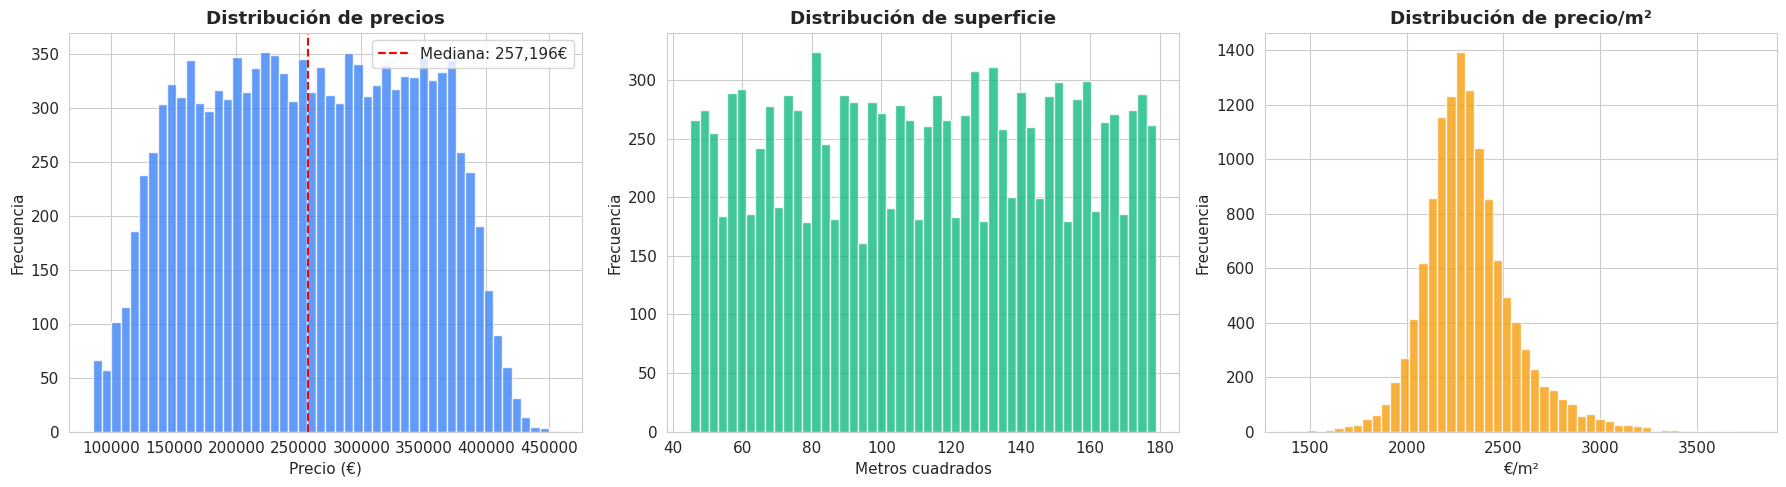

💾 Gráfico guardado en Reports/eda_distribuciones.png


In [6]:
# ==============================================================================
# 4. EDA — DISTRIBUCIÓN DE PRECIOS
# ==============================================================================
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 4.1 Histograma de precios
axes[0].hist(df['precio_actual'], bins=50, color='#3b82f6', edgecolor='white', alpha=0.8)
axes[0].set_title('Distribución de precios', fontweight='bold')
axes[0].set_xlabel('Precio (€)')
axes[0].set_ylabel('Frecuencia')
axes[0].axvline(df['precio_actual'].median(), color='red', linestyle='--', label=f"Mediana: {df['precio_actual'].median():,.0f}€")
axes[0].legend()

# 4.2 Histograma de metros
axes[1].hist(df['tamano_m2'], bins=50, color='#10b981', edgecolor='white', alpha=0.8)
axes[1].set_title('Distribución de superficie', fontweight='bold')
axes[1].set_xlabel('Metros cuadrados')
axes[1].set_ylabel('Frecuencia')

# 4.3 Precio por metro cuadrado
df['precio_m2'] = df['precio_actual'] / df['tamano_m2']
axes[2].hist(df['precio_m2'], bins=50, color='#f59e0b', edgecolor='white', alpha=0.8)
axes[2].set_title('Distribución de precio/m²', fontweight='bold')
axes[2].set_xlabel('€/m²')
axes[2].set_ylabel('Frecuencia')

plt.tight_layout()
plt.savefig(f'{REPORT_PATH}/eda_distribuciones.png', dpi=150, bbox_inches='tight')
plt.show()
print("💾 Gráfico guardado en Reports/eda_distribuciones.png")


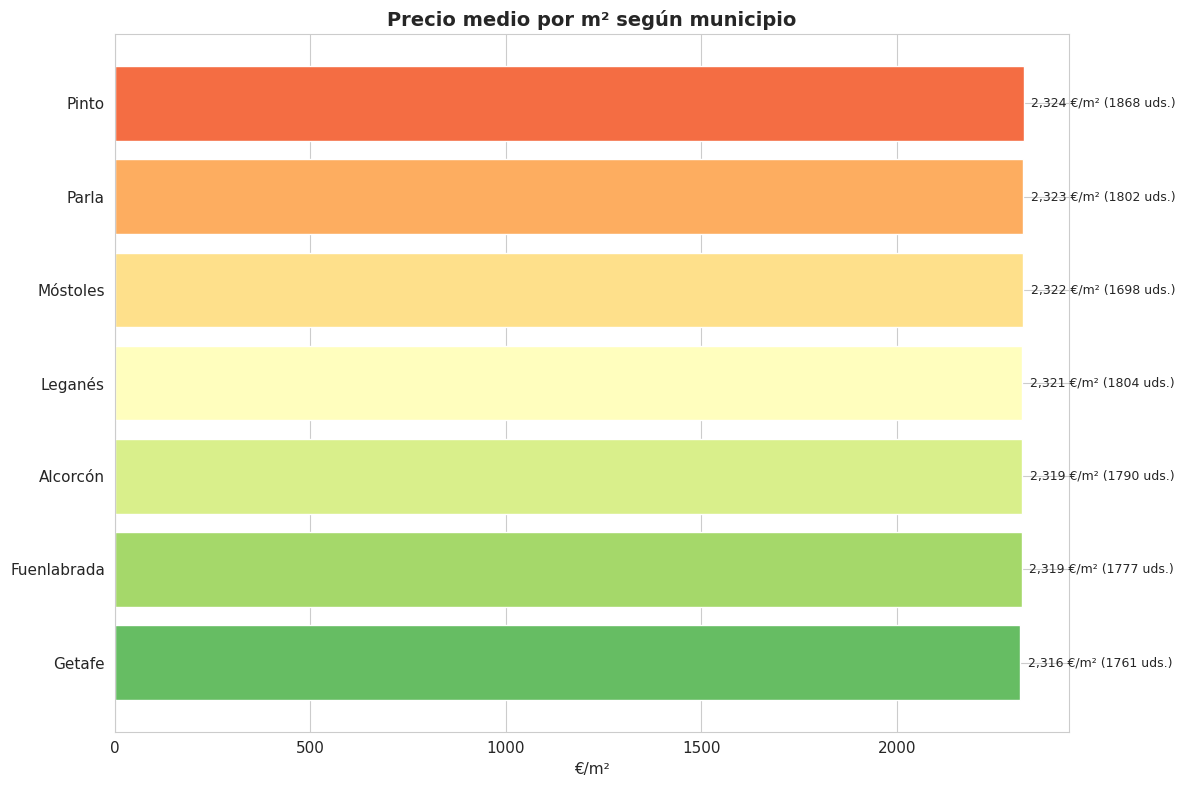

In [7]:
# ==============================================================================
# 4.2 PRECIO MEDIO POR MUNICIPIO (Top 15)
# ==============================================================================
precio_municipio = df.groupby('municipio').agg(
    precio_medio=('precio_actual', 'mean'),
    precio_m2_medio=('precio_m2', 'mean'),
    n_inmuebles=('id_anuncio', 'count')
).sort_values('precio_m2_medio', ascending=True)

fig, ax = plt.subplots(figsize=(12, 8))
colors = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(precio_municipio)))
bars = ax.barh(precio_municipio.index, precio_municipio['precio_m2_medio'], color=colors, edgecolor='white')

# Etiquetas
for bar, (_, row) in zip(bars, precio_municipio.iterrows()):
    ax.text(bar.get_width() + 20, bar.get_y() + bar.get_height()/2,
            f"{row['precio_m2_medio']:,.0f} €/m² ({int(row['n_inmuebles'])} uds.)",
            va='center', fontsize=9)

ax.set_title('Precio medio por m² según municipio', fontsize=14, fontweight='bold')
ax.set_xlabel('€/m²')
plt.tight_layout()
plt.savefig(f'{REPORT_PATH}/eda_precio_municipio.png', dpi=150, bbox_inches='tight')
plt.show()


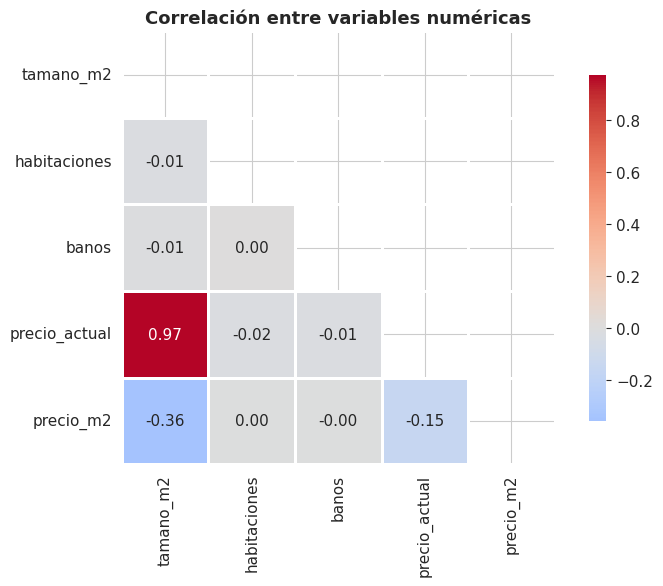

📊 Observaciones clave:
   • Correlación precio ~ m²: 0.973
   • Correlación precio ~ habitaciones: -0.015
   • Correlación precio ~ baños: -0.014


In [8]:
# ==============================================================================
# 4.3 MATRIZ DE CORRELACIÓN
# ==============================================================================
vars_numericas = ['tamano_m2', 'habitaciones', 'banos', 'precio_actual', 'precio_m2']
corr = df[vars_numericas].corr()

fig, ax = plt.subplots(figsize=(8, 6))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, square=True, linewidths=1, ax=ax,
            cbar_kws={'shrink': 0.8})
ax.set_title('Correlación entre variables numéricas', fontweight='bold', fontsize=13)
plt.tight_layout()
plt.savefig(f'{REPORT_PATH}/eda_correlaciones.png', dpi=150, bbox_inches='tight')
plt.show()

print("📊 Observaciones clave:")
print(f"   • Correlación precio ~ m²: {corr.loc['precio_actual','tamano_m2']:.3f}")
print(f"   • Correlación precio ~ habitaciones: {corr.loc['precio_actual','habitaciones']:.3f}")
print(f"   • Correlación precio ~ baños: {corr.loc['precio_actual','banos']:.3f}")


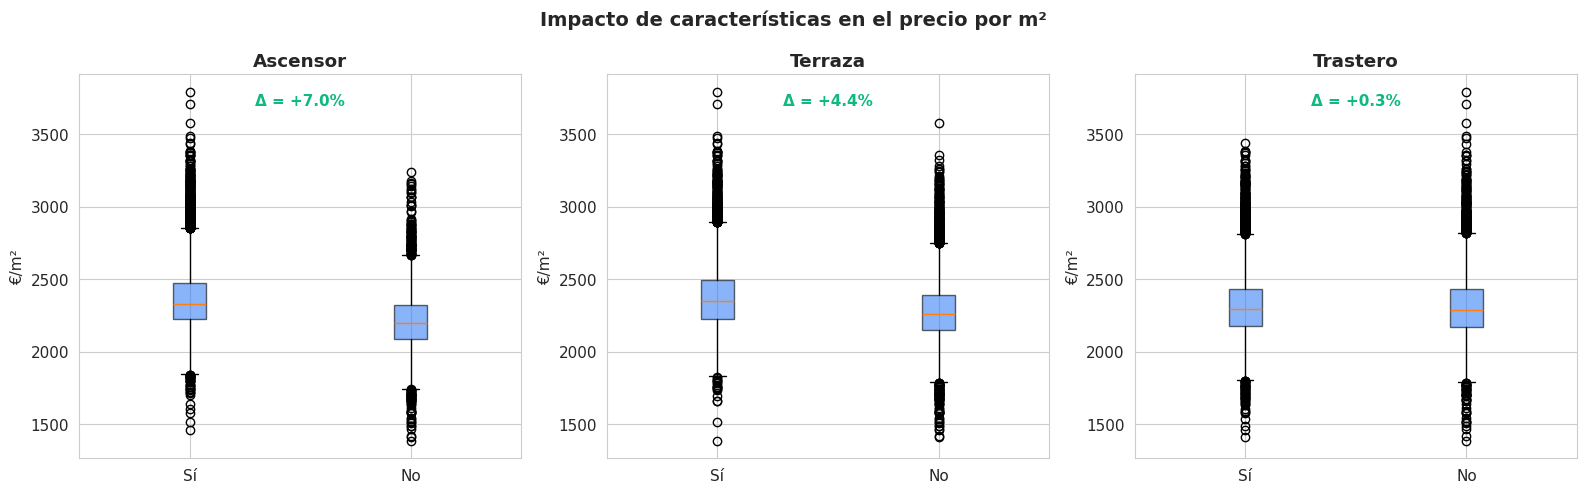

In [9]:
# ==============================================================================
# 4.4 IMPACTO DE CARACTERÍSTICAS BOOLEANAS EN EL PRECIO
# ==============================================================================
bool_vars = ['tiene_ascensor', 'tiene_terraza', 'tiene_trastero']

fig, axes = plt.subplots(1, 3, figsize=(16, 5))
for ax, var in zip(axes, bool_vars):
    data = [df[df[var]==True]['precio_m2'], df[df[var]==False]['precio_m2']]
    bp = ax.boxplot(data, labels=['Sí', 'No'], patch_artist=True,
                    boxprops=dict(facecolor='#3b82f6', alpha=0.6))

    medias = [d.mean() for d in data]
    ax.set_title(f'{var.replace("tiene_", "").title()}', fontweight='bold')
    ax.set_ylabel('€/m²')

    diff_pct = (medias[0] - medias[1]) / medias[1] * 100
    color = '#10b981' if diff_pct > 0 else '#ef4444'
    ax.text(0.5, 0.95, f'Δ = {diff_pct:+.1f}%', transform=ax.transAxes,
            ha='center', va='top', fontsize=11, fontweight='bold', color=color)

plt.suptitle('Impacto de características en el precio por m²', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(f'{REPORT_PATH}/eda_impacto_booleanas.png', dpi=150, bbox_inches='tight')
plt.show()


## 5. Inventario de imágenes disponibles

Una parte fundamental de este TFM es demostrar que las **imágenes mejoran la predicción** de precios. Por eso necesito hacer un inventario de las fotografías disponibles y vincularlas con los registros del dataset.

Dispongo de 300 imágenes reales de interiores de inmuebles que voy a cruzar con el dataset tabular.


In [10]:
# ==============================================================================
# 5. INVENTARIO DE IMÁGENES
# ==============================================================================
import glob

# Listar imágenes disponibles
imagenes = sorted(glob.glob(f'{IMG_PATH}/casa_dataset_*.jpg'))
print(f"🖼️  Imágenes encontradas: {len(imagenes)}")

if len(imagenes) > 0:
    # Extraer números de las imágenes
    import re
    img_indices = []
    for img_path in imagenes:
        match = re.search(r'casa_dataset_(\d+)', img_path)
        if match:
            img_indices.append(int(match.group(1)))

    img_indices = sorted(set(img_indices))
    print(f"   Rango: {min(img_indices)} a {max(img_indices)}")
    print(f"   Índices únicos: {len(img_indices)}")

    # Crear columna de mapping: asignamos imagen i al registro i del dataset
    df['tiene_imagen'] = False
    df['path_imagen'] = None

    for idx in img_indices:
        if idx < len(df):
            img_file = f'{IMG_PATH}/casa_dataset_{idx}.jpg'
            if os.path.exists(img_file):
                df.loc[idx, 'tiene_imagen'] = True
                df.loc[idx, 'path_imagen'] = img_file

    n_con_imagen = df['tiene_imagen'].sum()
    print(f"\n📊 Registros vinculados con imagen: {n_con_imagen} de {len(df):,}")
    print(f"   ({n_con_imagen/len(df)*100:.1f}% del dataset)")
else:
    print("⚠️  No se encontraron imágenes. Verifica la ruta:", IMG_PATH)
    df['tiene_imagen'] = False
    df['path_imagen'] = None


🖼️  Imágenes encontradas: 300
   Rango: 0 a 299
   Índices únicos: 300

📊 Registros vinculados con imagen: 300 de 12,500
   (2.4% del dataset)


In [11]:
# ==============================================================================
# 5.2 GALERÍA VISUAL — Muestra de imágenes vinculadas
# ==============================================================================
df_con_img = df[df['tiene_imagen']].head(8)

if len(df_con_img) > 0:
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.flatten()

    for ax, (_, row) in zip(axes, df_con_img.iterrows()):
        try:
            img = Image.open(row['path_imagen'])
            ax.imshow(img)
            ax.set_title(f"{row['municipio']}\n{row['precio_actual']:,.0f}€ | {row['tamano_m2']}m²",
                        fontsize=9, fontweight='bold')
        except Exception as e:
            ax.text(0.5, 0.5, f'Error: {e}', transform=ax.transAxes, ha='center')
        ax.axis('off')

    plt.suptitle('Galería: Imágenes reales vinculadas al dataset', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'{REPORT_PATH}/galeria_imagenes.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("💾 Galería guardada en Reports/galeria_imagenes.png")
else:
    print("⚠️  No hay imágenes para mostrar.")


Output hidden; open in https://colab.research.google.com to view.

In [12]:
# ==============================================================================
# 5.3 COMPARACIÓN: Registros con imagen vs sin imagen
# ==============================================================================
print("📊 Comparativa estadística: registros CON imagen vs SIN imagen\n")

comparativa = df.groupby('tiene_imagen').agg(
    n=('id_anuncio', 'count'),
    precio_medio=('precio_actual', 'mean'),
    m2_medio=('tamano_m2', 'mean'),
    precio_m2_medio=('precio_m2', 'mean')
).round(0)

comparativa.index = ['Sin imagen', 'Con imagen']
print(comparativa.to_string())

print(f"\n💡 Nota: Los {int(comparativa.loc['Con imagen','n'])} registros con imagen")
print(f"   serán utilizados en el Módulo 3 para entrenar el modelo híbrido")
print(f"   (tabular + visión por computador) y comparar con el baseline puramente tabular.")


📊 Comparativa estadística: registros CON imagen vs SIN imagen

                n  precio_medio  m2_medio  precio_m2_medio
Sin imagen  12200      257524.0     112.0           2320.0
Con imagen    300      251182.0     109.0           2352.0

💡 Nota: Los 300 registros con imagen
   serán utilizados en el Módulo 3 para entrenar el modelo híbrido
   (tabular + visión por computador) y comparar con el baseline puramente tabular.


## 6. Exportación del dato auditado

Guardo el dataset con la nueva columna `tiene_imagen` y `path_imagen` para que el siguiente módulo (Preprocesamiento) trabaje directamente con datos verificados.


In [13]:
# ==============================================================================
# 6. EXPORTACIÓN
# ==============================================================================

# Guardar dataset auditado
output_path = f'{PROC_PATH}/datos_auditados.csv'
df.to_csv(output_path, index=False)

print(f"💾 Dataset auditado exportado: {output_path}")
print(f"   → {df.shape[0]:,} registros x {df.shape[1]} variables")
print(f"   → {df['tiene_imagen'].sum()} registros con imagen vinculada")
print(f"\n{'='*60}")
print("📋 RESUMEN FINAL DEL MÓDULO 1")
print(f"{'='*60}")
print(f"   Registros totales: {df.shape[0]:,}")
print(f"   Variables: {df.shape[1]}")
print(f"   Nulos: {df.isnull().sum().sum()}")
print(f"   Duplicados: {df.duplicated().sum()}")
print(f"   Rango precios: {df['precio_actual'].min():,.0f}€ — {df['precio_actual'].max():,.0f}€")
print(f"   Municipios: {df['municipio'].nunique()}")
print(f"   Imágenes vinculadas: {df['tiene_imagen'].sum()}")
print(f"\n✅ Dato auditado y listo para el Módulo 2 (Preprocesamiento)")


💾 Dataset auditado exportado: /content/drive/MyDrive/TFM_Mejorado/Data/Processed/datos_auditados.csv
   → 12,500 registros x 20 variables
   → 300 registros con imagen vinculada

📋 RESUMEN FINAL DEL MÓDULO 1
   Registros totales: 12,500
   Variables: 20
   Nulos: 12200
   Duplicados: 0
   Rango precios: 85,000€ — 457,684€
   Municipios: 7
   Imágenes vinculadas: 300

✅ Dato auditado y listo para el Módulo 2 (Preprocesamiento)
